# FEM-BEM coupling of Poisson-Boltzmann - Arginine

## Entry data

In [1]:
import dolfin
import bempp.api
from bempp.api.external.fenics import FenicsOperator
from dolfin_utils.meshconvert import meshconvert
import numpy as np
from bempp.api.external import fenics
from scipy.sparse.linalg import cg, minres
import pylab as plt
import time

from scipy.sparse.linalg import gmres
from scipy.sparse.linalg import LinearOperator
from bempp.api.assembly.discrete_boundary_operator import InverseSparseDiscreteBoundaryOperator
from bempp.api.assembly.blocked_operator import BlockedDiscreteOperator

from bempp.api.operators.boundary import sparse, laplace, modified_helmholtz
from bempp.api.operators.potential import laplace as lp
 
# Problem data #
tol = 1e-06         # Tolerance
fmm = 0             # Use FMM

# Problem data #
from readpqr_all import readpqr_all
[PC, Q, R] = readpqr_all('./arginine/arg.pqr')         # Charges, Points of charges and Radiuses
w = 0.1250                                             # kappa
es = 80.                                               # External permitivity (solvant)
em = 4.                                                # Internal permitivity (molecule)

ec = 1.602176e-19 #[C]
kb = 1.380648e-23 #[J/K]
T  = 300 #[K]
S1 = 1 #(ec/(kb*T))  #38.681 [C/J]

# Result collecting lists #
solv_error = []
mesh_size = []
iter_num = []
time_solve = []

# Iteratotion for mesh #
grid_size = [2, 4, 8, 16] 

## Solving problems for each of the mesh

In [2]:
for m in grid_size:
    ######################### Mesh and spaces ##################################
    import os.path

    mesh = dolfin.Mesh("./arginine/arg_d0"+format(m)+"_surf.xml")

    nor = dolfin.FacetNormal(mesh) 
    
    # Spaces for FEM and BEM
    fenics_space = dolfin.FunctionSpace(mesh, "CG", 1)
    trace_space, trace_matrix = \
        fenics.fenics_to_bempp_trace_data(fenics_space)
    bempp_space = bempp.api.function_space(trace_space.grid, "P", 1)

    # Mesh size information #
    print("FEM dofs: {0}".format(mesh.num_vertices()))
    print("BEM dofs: {0}".format(bempp_space.global_dof_count))
    hmax = trace_space.grid.maximum_element_diameter
    mesh_size.append(hmax)
    
    # FEM discrete variables
    u = dolfin.TrialFunction(fenics_space)
    v = dolfin.TestFunction(fenics_space)
    
    # BEM operators
    id_op = bempp.api.operators.boundary.sparse.identity(trace_space, bempp_space, bempp_space)
    mass = bempp.api.operators.boundary.sparse.identity(bempp_space, bempp_space, trace_space)

    if fmm:
        dlp_0 = bempp.api.operators.boundary.laplace.double_layer(trace_space, bempp_space, bempp_space, assembler="fmm")
        slp_0 = bempp.api.operators.boundary.laplace.single_layer(bempp_space, bempp_space, bempp_space, assembler="fmm")

        dlp = bempp.api.operators.boundary.modified_helmholtz.double_layer(trace_space, bempp_space, bempp_space, w, assembler="fmm")
        slp = bempp.api.operators.boundary.modified_helmholtz.single_layer(bempp_space, bempp_space, bempp_space, w, assembler="fmm")
    else:
        dlp_0 = bempp.api.operators.boundary.laplace.double_layer(trace_space, bempp_space, bempp_space)
        slp_0 = bempp.api.operators.boundary.laplace.single_layer(bempp_space, bempp_space, bempp_space)

        dlp = bempp.api.operators.boundary.modified_helmholtz.double_layer(trace_space, bempp_space, bempp_space, w)
        slp = bempp.api.operators.boundary.modified_helmholtz.single_layer(bempp_space, bempp_space, bempp_space, w)

   ######################### Matrix and RHS ##################################
    
    # RHS for FEM
    rhs_f = dolfin.Constant(0.0)
    rhs_fem = dolfin.assemble(rhs_f*v*dolfin.dx)
    for i in range(len(PC)):
        delta = dolfin.PointSource(fenics_space, dolfin.Point(PC[i]), Q[i]/em)
        delta.apply(rhs_fem)
    # RHS for BEM
    rhs_bem = np.zeros(bempp_space.global_dof_count)
    # Global RHS
    rhs = np.concatenate([rhs_fem, rhs_bem])
    
    
    blocks = [[None,None],[None,None]]
    blocks_vac = [[None,None],[None,None]]
    
    # FEM matrices
    trace_op = LinearOperator(trace_matrix.shape, lambda x:trace_matrix*x)

    A = FenicsOperator((dolfin.inner(dolfin.nabla_grad(u),
                                     dolfin.nabla_grad(v)) ) * dolfin.dx)  
    # Solvant case
    B00 = A.weak_form()
    B01 = -trace_matrix.T * mass.weak_form().A
    B10 = (.5 * id_op - dlp).weak_form().A * trace_matrix
    B11 = slp.weak_form().A*(em/es)
    blocks[0][0] = B00.A  #A
    blocks[0][1] = B01  #-ML
    blocks[1][0] = B10  #0.5-K
    blocks[1][1] = B11  #V

    blocked = BlockedDiscreteOperator(np.array(blocks))
    
    ######################### Preconditioner and solvers ##################################
    from scipy.sparse import diags
    
    # Diagonal Scaling #
    P1 = diags(1./blocked[0,0].diagonal())

    # Mass matrix preconditioner #
    P2 = InverseSparseDiscreteBoundaryOperator(
        bempp.api.operators.boundary.sparse.identity(
            bempp_space, bempp_space, bempp_space).weak_form())

    # Create a block diagonal preconditioner object using the Scipy LinearOperator class
    def apply_prec(x):
        """Apply the block diagonal preconditioner"""
        m1 = P1.shape[0]
        m2 = P2.shape[0]
        n1 = P1.shape[1]
        n2 = P2.shape[1]

        res1 = P1.dot(x[:n1]) 
        res2 = P2.dot(x[n1:])
        return np.concatenate([res1, res2])

    p_shape = (P1.shape[0] + P2.shape[0], P1.shape[1] + P2.shape[1])
    P = LinearOperator(p_shape, apply_prec, dtype=np.dtype('float64'))

    it_count = 0
    def count_iterations(x):
        global it_count
        it_count += 1

    from scipy.sparse.linalg import gmres
    start = time.time()     
    soln, info = gmres(blocked, rhs, M=P, callback=count_iterations, tol=tol, restrt=500)
    end = time.time()
    curr_time = (end - start) 
    time_solve.append(curr_time)  
                       
    soln_fem = soln[:mesh.num_vertices()]
    soln_bem = soln[mesh.num_vertices():]

    print("Number of iterations: {0}".format(it_count))
    iter_num.append(it_count)
    
    u = dolfin.Function(fenics_space)
    u.vector()[:] = np.ascontiguousarray(np.real(soln_fem))
    dirichlet_data = trace_matrix * soln_fem
    dirichlet_fun = bempp.api.GridFunction(trace_space, coefficients=dirichlet_data)
    neumann_fun = bempp.api.GridFunction(bempp_space, coefficients=soln_bem)
   
    ######################### Solvation energy ##################################
    
    slpF = bempp.api.operators.potential.laplace.single_layer(bempp_space, np.transpose(PC)) 
    dlpF = bempp.api.operators.potential.laplace.double_layer(trace_space, np.transpose(PC))

    uF = slpF * neumann_fun - dlpF * dirichlet_fun

    q_uF = 0
    for i in range(len(PC)):
        Sum = (uF[0][i].real)*Q[i]
        q_uF = q_uF + Sum

    E_Solv = 0.5*4.*np.pi*332.064*(q_uF) 
    print('Energia de Solvatacion : {:7.3f} [kCal/mol]'.format(E_Solv))
    
    solv_error.append(E_Solv)    

FEM dofs: 682
BEM dofs: 403


/usr/lib/python3/dist-packages/scipy/sparse/linalg/dsolve/linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)


Number of iterations: 262
Energia de Solvatacion : -26.320 [kCal/mol]
FEM dofs: 1466
BEM dofs: 825


/usr/lib/python3/dist-packages/scipy/sparse/linalg/dsolve/linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)


Number of iterations: 261
Energia de Solvatacion : -25.700 [kCal/mol]
FEM dofs: 2762
BEM dofs: 1572


/usr/lib/python3/dist-packages/scipy/sparse/linalg/dsolve/linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)


Number of iterations: 246
Energia de Solvatacion : -24.117 [kCal/mol]
FEM dofs: 5674
BEM dofs: 3262


/usr/lib/python3/dist-packages/scipy/sparse/linalg/dsolve/linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)


Number of iterations: 252
Energia de Solvatacion : -24.228 [kCal/mol]


## Ploting the results and saving for comparison to BEM-BEM and FEM-BEM coupling formulations

## Solvation energy

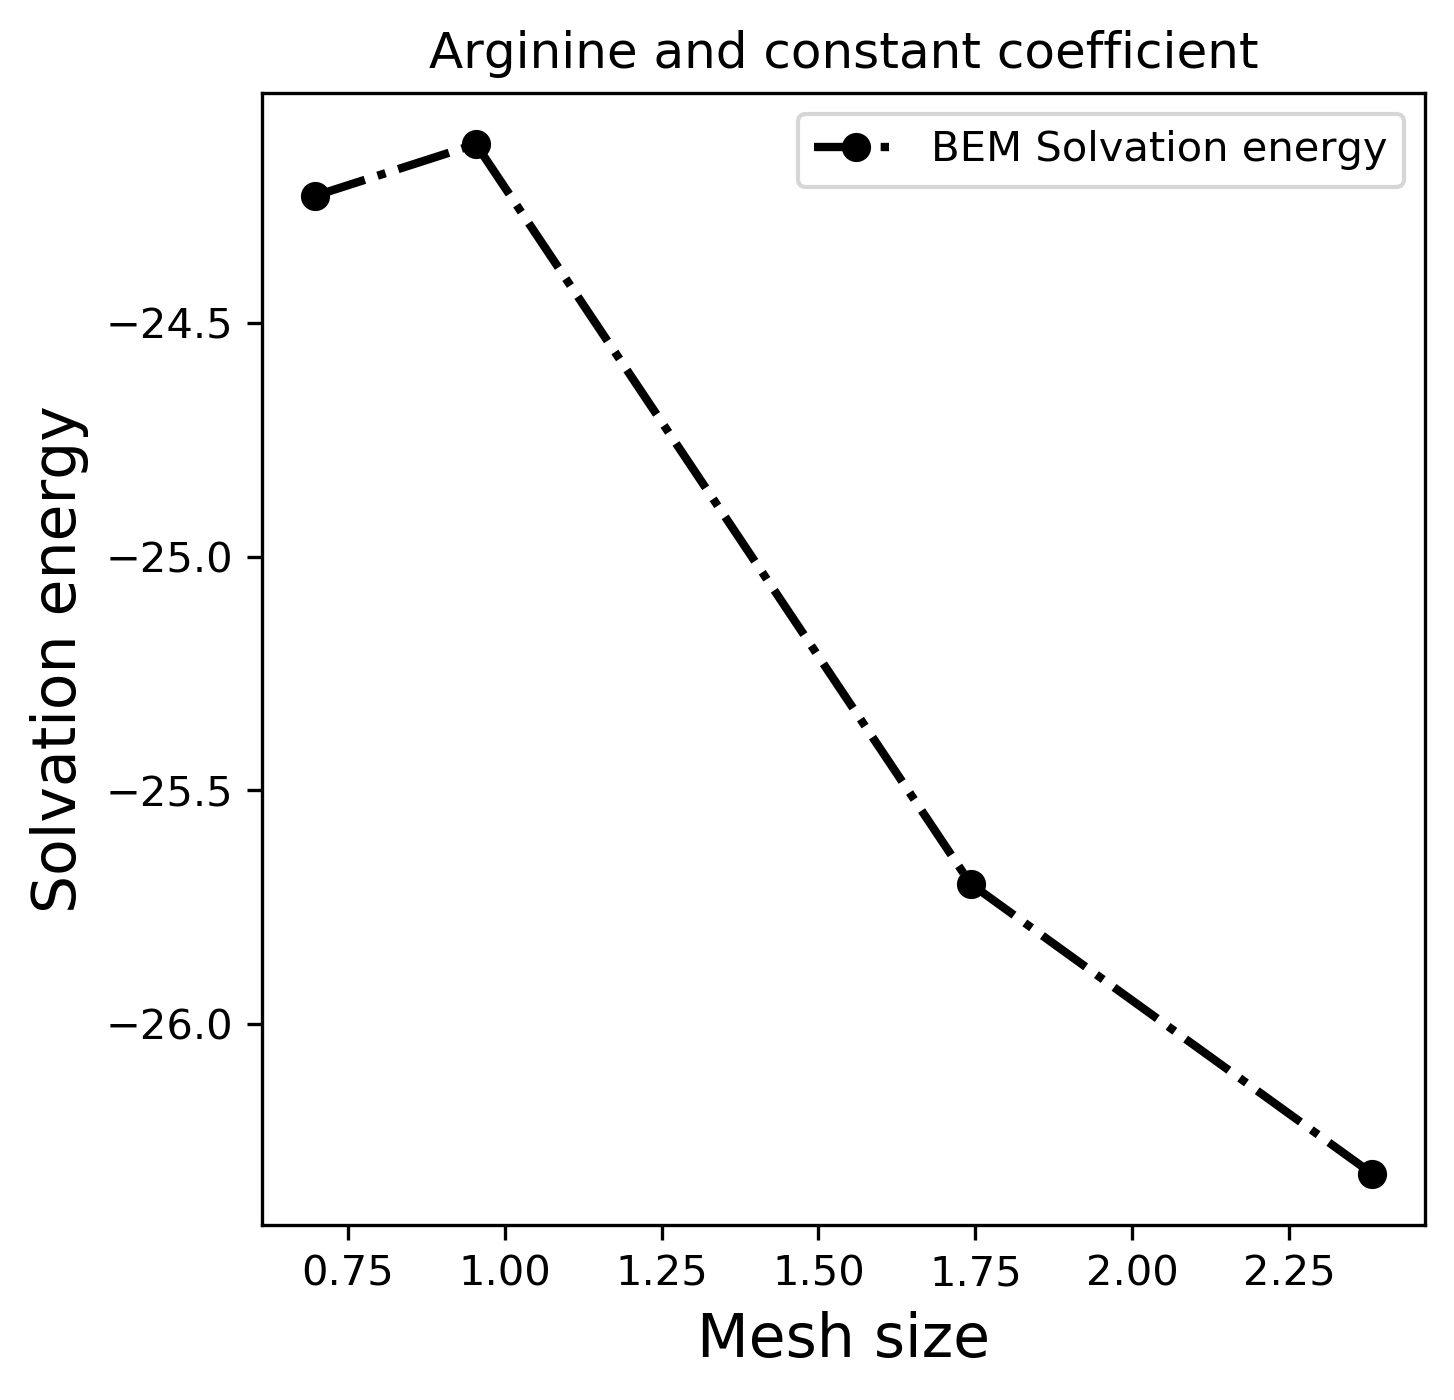

In [3]:
from operator import add
import matplotlib.pyplot as plt

with open('FEM_BEM_Arginine_Const_error.npy', 'wb') as f:
    np.save(f, np.array(solv_error))

plt.figure( figsize=(5, 5), dpi=300)
plt.plot(mesh_size, solv_error, 'ko-.', linewidth=2, label='BEM Solvation energy')
plt.legend(loc='best')
plt.title('Arginine and constant coefficient')
plt.xlabel('Mesh size', fontsize='x-large')
plt.ylabel('Solvation energy', fontsize='x-large')
plt.show()

## Iteration count

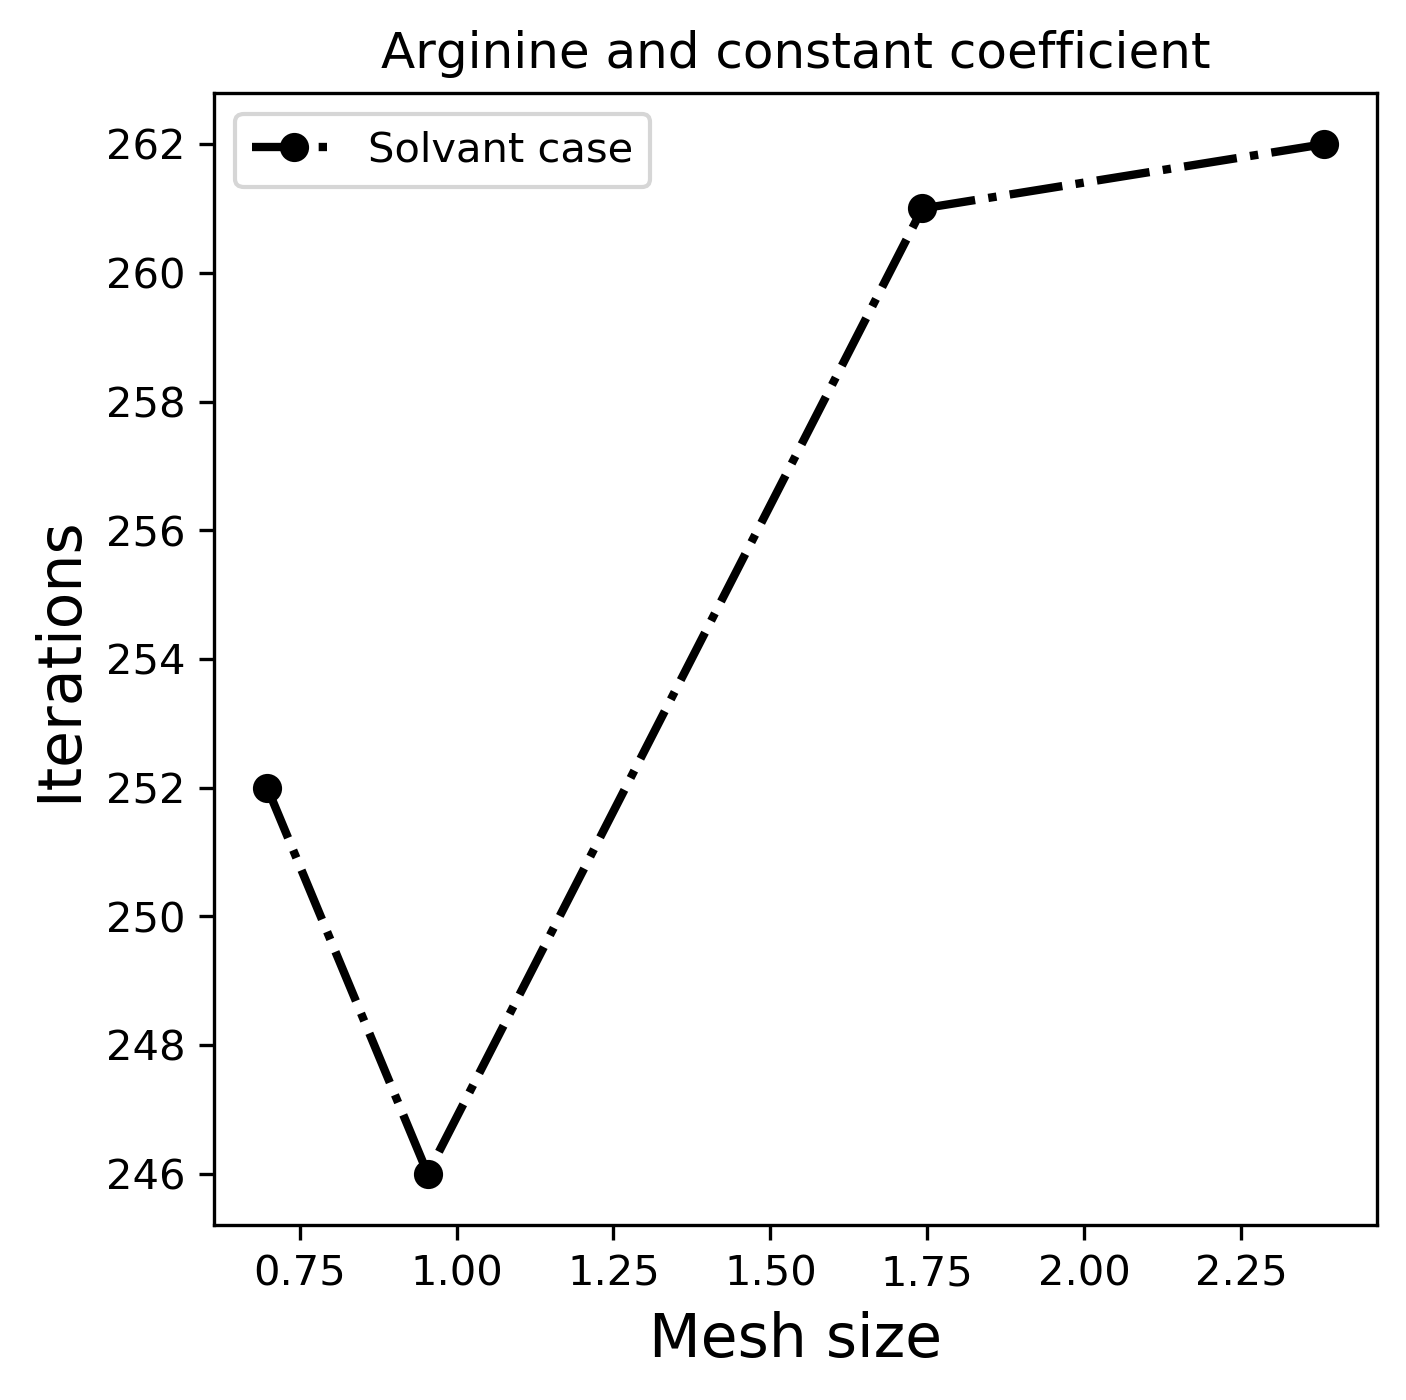

In [4]:
import matplotlib.pyplot as plt

log_mesh_size = np.log(mesh_size)

with open('FEM_BEM_Arginine_Const_iter.npy', 'wb') as f:
    np.save(f, np.array(iter_num))

plt.figure( figsize=(5, 5), dpi=300)
plt.plot(mesh_size, iter_num, 'ko-.', linewidth=2, label='Solvant case')
plt.legend(loc='best')
plt.title('Arginine and constant coefficient')
plt.xlabel('Mesh size', fontsize='x-large')
plt.ylabel('Iterations', fontsize='x-large')
plt.show()

## Computational cost

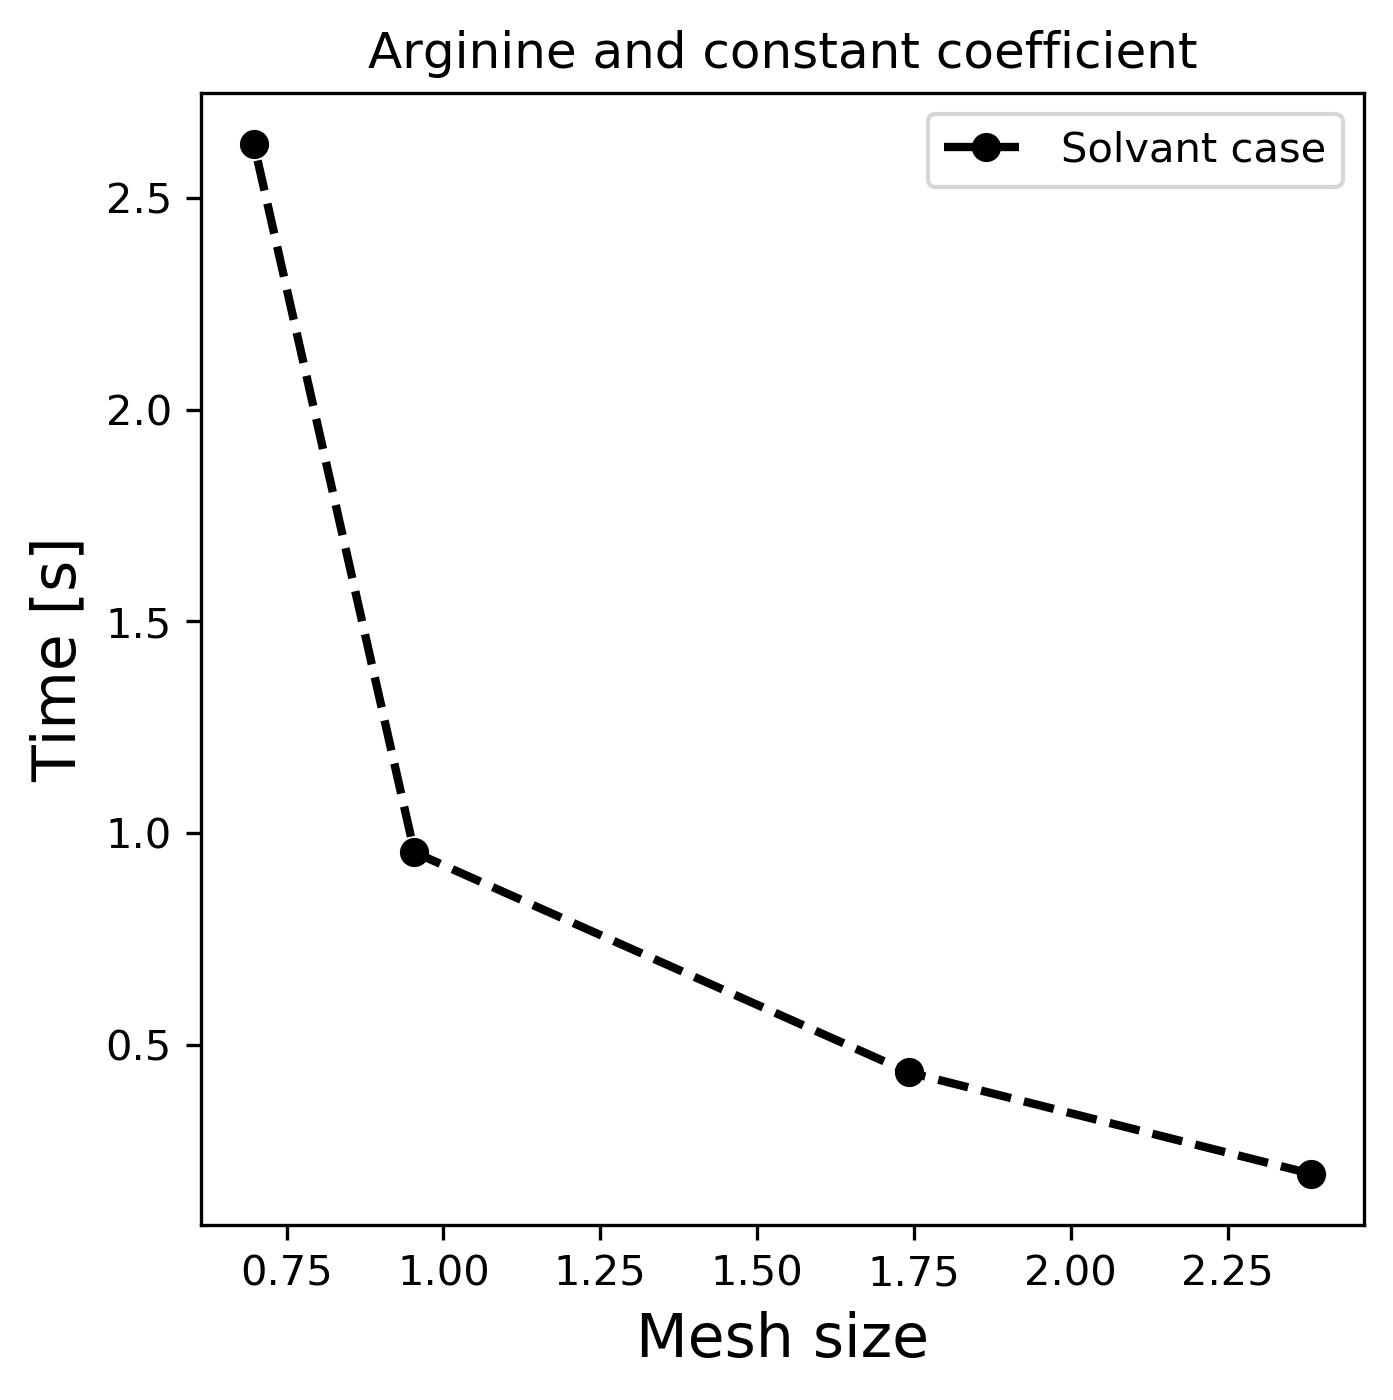

In [5]:
import matplotlib.pyplot as plt

log_mesh_size = np.log(mesh_size)

with open('FEM_BEM_Arginine_Const_time.npy', 'wb') as f:
    np.save(f, np.array(time_solve))

plt.figure( figsize=(5, 5), dpi=300)
plt.plot(mesh_size, time_solve, 'ko--', linewidth=2, label='Solvant case')
plt.legend(loc='best')
plt.title('Arginine and constant coefficient')
plt.xlabel('Mesh size', fontsize='x-large')
plt.ylabel('Time [s]', fontsize='x-large')
plt.show()